# DeMetRA - static figures 

In [80]:
import pandas as pd
import numpy as np
# import os
# os.getcwd()

import matplotlib.pyplot as plt

In [79]:
results_directory = 'src_shiny_app/assets/'

lit, base_ss, base_va = pd.read_excel(f'{results_directory}MPS_review_systematic_2025-02-14.xlsx', sheet_name=[0, 1, 2]).values()

# d = d_raw.loc[d_raw.Include == 'Yes'].drop('Include', axis=1) # All included

# print(lit.shape, '\n', list(lit.columns))
# print(base_ss.shape, '\n', list(base_ss.columns))
# print(base_va.shape, '\n', list(base_va.columns))

/Users/Serena/Desktop/DEMETRA/DeMetRA-review/demetra_venv/lib/python3.9/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)
/Users/Serena/Desktop/DEMETRA/DeMetRA-review/demetra_venv/lib/python3.9/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)


## Data cleaning

In [9]:
# Inspect values 
def checklvl(var):
    allobs = pd.concat([lit[var], base_ss[var], base_va[var]])
    print(allobs.value_counts(dropna=False))

for v in  ['Tissue', 'Array','Ancestry','Developmental_period']:
    checklvl(v)
    print('\n')
    try: 
        checklvl(f'Multiple_{v.lower()}')
        print('\n')
    except:
        pass

# NOTE: this is to guide manual cleaning of the excel file!

Tissue
Peripheral blood          497
Whole blood               153
Saliva                    120
Cord blood                 48
Dried bloodspot            26
Blood-clots                26
Buccal cells               21
Placenta                   15
Tumour cells                7
Nasal epithelial cells      7
Multiple                    4
Leukocytes                  4
Not reported                1
Cervical cells              1
Name: count, dtype: int64


Multiple_tissue
NaN                            926
Whole blood, HPCs                2
Cord blood, Dried bloodspot      1
Cord blood, Whole blood          1
Name: count, dtype: int64


Array
Multiple    436
EPICv1      289
450K        191
WGBS         14
Name: count, dtype: int64


Multiple_array
NaN                                    494
450K, EPICv1                           426
450K, GMEL (~3000 CpGs from EPICv1)      6
450K, EPICv2                             2
450K, EPICv3                             1
450K, EPICv4                     

In [81]:
# Recode "multiple"
def replace_multiples(df):

    for var in ['Tissue', 'Array', 'Ancestry']:
    
        if var == 'Ancestry':
            df.loc[df[var] == 'Multiple', var] = 'Mixed'
    
        else:
            df.loc[df[var] == 'Multiple', var] = [f'Multiple ({values})' for values in df.loc[df[var] == 'Multiple', f'Multiple_{var.lower()}']]
        
        # print(df[var].value_counts(), '\n')
    
    return df

lit = replace_multiples(lit)
base_ss = replace_multiples(base_ss)
base_va = replace_multiples(base_va)

In [87]:
# Merging
d2_vars = ['Identifier', # 'Identifier_base', 'Multiple_identifier_base'
           'Category', 'Phenotype', 
           'Tissue',
           'Array',
           'Ancestry',
           'Developmental_period', 
           'Covariates']

d1_vars = ['Identifier_base', # 'Multiple_identifier_base' ??
           'Title', 'Year', 'What_is_available', 'Sample_overlap_target_base']+d2_vars[1:]

# There is not overlap between BASE reference 
# any([i in base_va.Identifier for i in  base_ss.Identifier])
d_base = pd.concat([base_ss[d2_vars], base_va[d2_vars]], axis=0)
d_base['MPS_id'] = d_base['Identifier'] + d_base['Phenotype']
print(d_base.shape, '\n', list(d_base.columns))

d_targ = lit.loc[lit.What_is_available != 'Only phenotype', d1_vars]
d_targ['MPS_id'] = d_targ['Identifier_base'] + d_targ['Phenotype']
d_targ = d_targ.rename(columns={'Identifier_base': 'Identifier'})

print(d_targ.shape, '\n', list(d_targ.columns))

# Merge info about target with info about base (for summary statistics)
d = d_targ.merge(d_base, on='MPS_id',
                 # left_on='Identifier_base', right_on='Identifier',
                 how='left', suffixes=['_targ','_base'])

# TMP
mismatch = d.loc[d['Identifier_base'].isna(), ]
d = d.loc[d['Identifier_base'].notna(), ] # Effectively inner join...
d.shape

(170, 9) 
 ['Identifier', 'Category', 'Phenotype', 'Tissue', 'Array', 'Ancestry', 'Developmental_period', 'Covariates', 'MPS_id']
(283, 13) 
 ['Identifier', 'Title', 'Year', 'What_is_available', 'Sample_overlap_target_base', 'Category', 'Phenotype', 'Tissue', 'Array', 'Ancestry', 'Developmental_period', 'Covariates', 'MPS_id']


(267, 21)

In [ ]:
# "Identifier_base" in the validated_algorithm - ignore? 

In [11]:
# What to do with the "multiple" bases ?  Excluded for now 
lit.loc[lit.Identifier_base == 'Multiple', ['Title', 'Multiple_identifier_base']]

,Title,Multiple_identifier_base
81,Blood-based DNA methylation study of alcohol c...,"Liu (2018) - A DNA methylation biomarker of, D..."
434,Nasal DNA methylation at three CpG sites predi...,Xu (2021) - Shared DNA methylation signatures ...
435,Nasal DNA methylation at three CpG sites predi...,Xu (2021) - Shared DNA methylation signatures ...
436,Nasal DNA methylation at three CpG sites predi...,Xu (2021) - Shared DNA methylation signatures ...
437,Nasal DNA methylation at three CpG sites predi...,Xu (2021) - Shared DNA methylation signatures ...
438,Nasal DNA methylation at three CpG sites predi...,Xu (2021) - Shared DNA methylation signatures ...
439,Nasal DNA methylation at three CpG sites predi...,Xu (2021) - Shared DNA methylation signatures ...


In [79]:
# mismatch

# 21 mismatches... dropping them for now 
# Drop mismatches for now-- discuss with Is how to handle them 
# Richmond (2018) - DNA methylation as a marker --- does not match becasue two kinds of maternal smoking ...
# Gondolia (2019) - Methylome-wide association study provides --- not match because Air Polution vs PM 
# Stevenson (2021) - Creating and Validating a DNA --- IL6 vs IL-6: CHANGED IT 
# Levy (2022) - Novel diagnostic DNA methylation --- different disorders mismatch...?
# Awamleh (2022) - DNA methylation signature ass --- different syndromes?
# Portales-Casamar (2016) - DNA methylation sign --- fetal alcohol syndrome ONLY? or also prenatal alcohol exposure 
# Aref-Eshghi (2019) - Evaluation of DNA Methyla --- Genitopatellar syndrome (GTPTS) and Ohdo syndrome, SBBYSS variant (SBBYSS)...  matching wich?
# ...

# Identifier base == multiple. What do you mean, combined? 


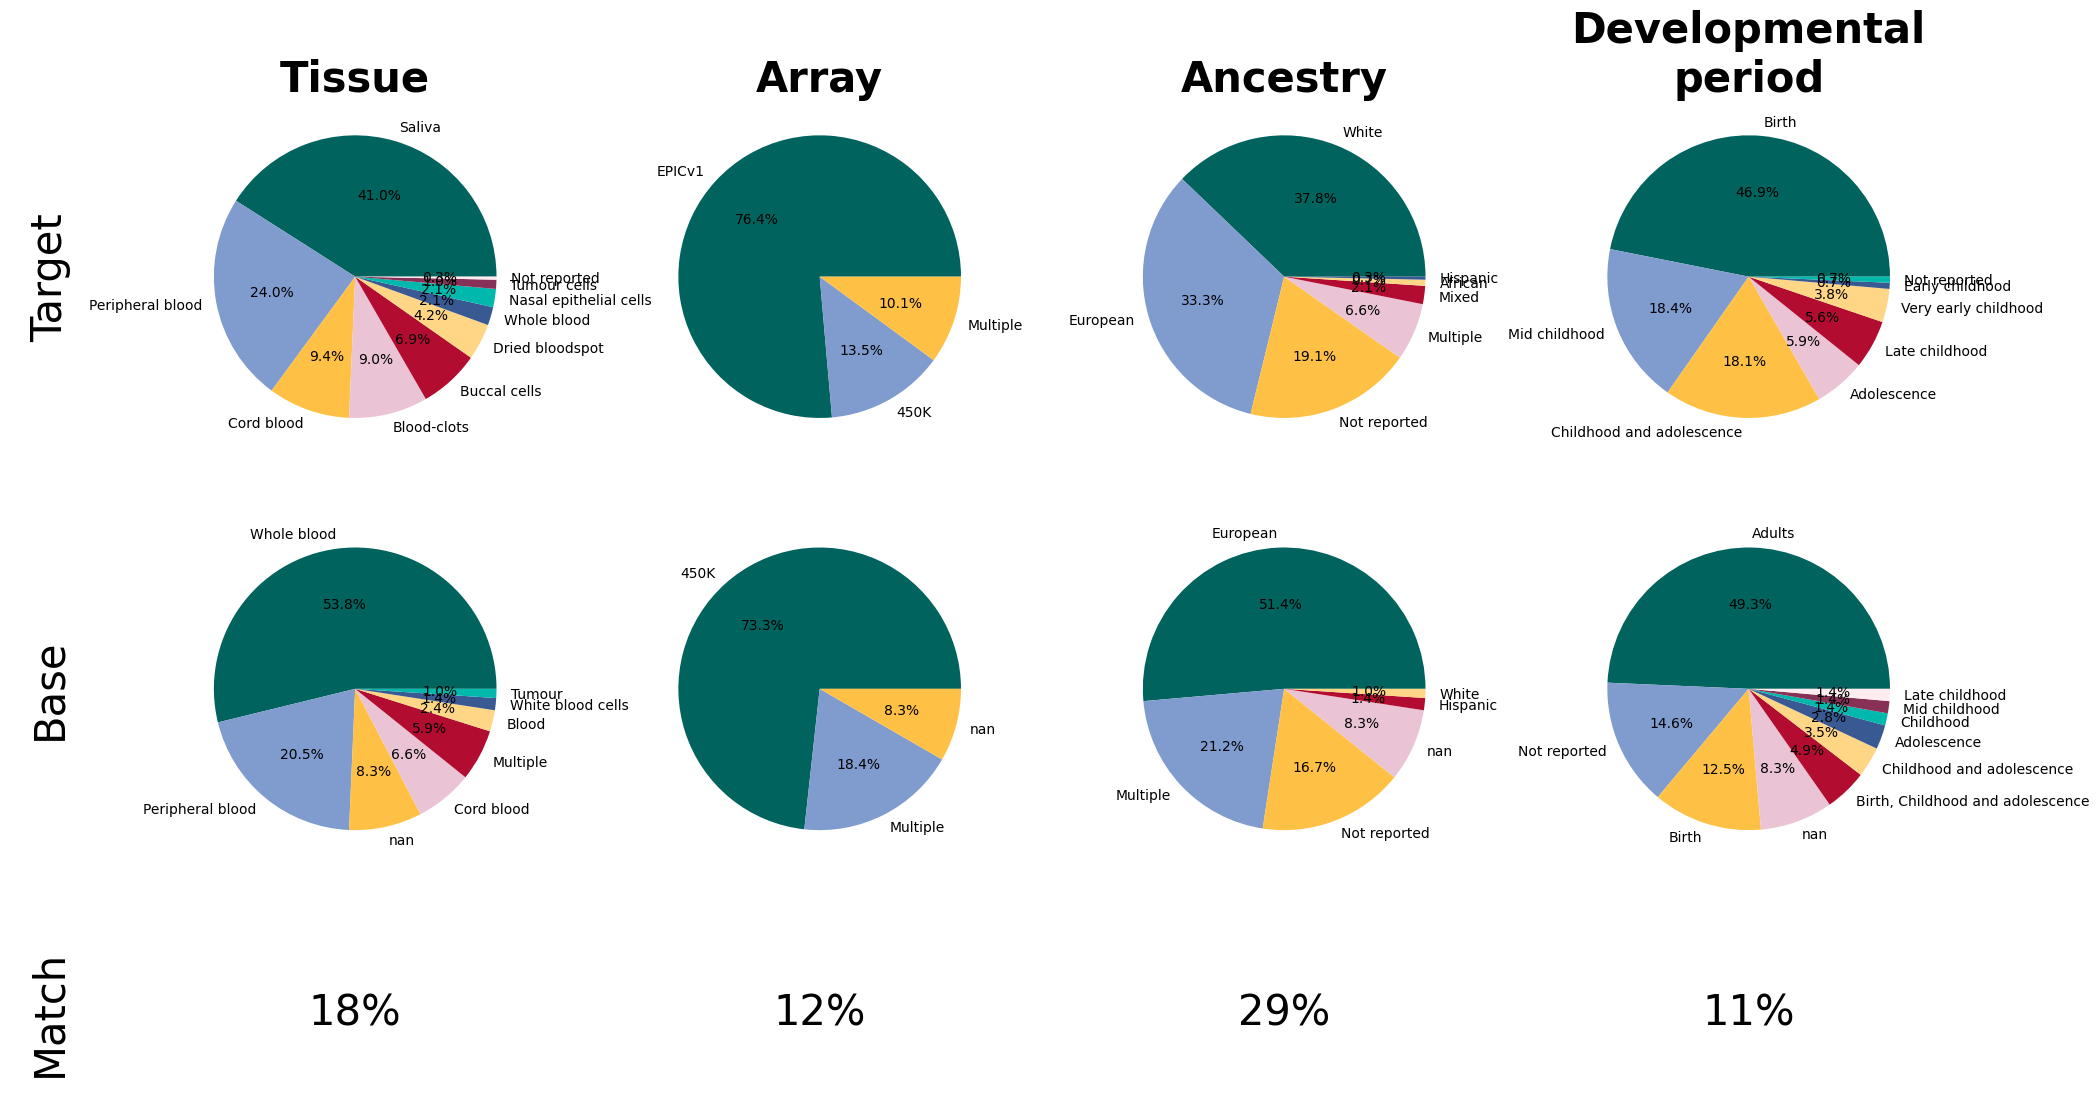

In [49]:
# Pie charts
demetra_pallete = {
    'caribbean-current': '#00635dff',
    'vista-blue': '#809bceff',
    'xanthous': '#ffc145ff',
    'fairy-tale': '#eac4d5ff',
    'red-ncs': '#b20d30ff',
    'jasmine': '#ffd685ff',
    'yinmn-blue': '#395993ff',
    'light-sea-green': '#00b8abff',
    'quinacridone-magenta': '#873157ff',
    'lavender-blush': '#feecf0ff'}

def pie_count(ax, var, df=d):

    count = df.value_counts(var, dropna=False)
    labels = count.index
    sizes = count
    
    ax.pie(sizes, labels=labels, autopct='%1.1f%%', colors=demetra_pallete.values())


def base_target_overlap(var, df=d):
    ovlp = df[f'{var}_base'] == df[f'{var}_targ']
    return(f'{round((sum(ovlp) / len(ovlp))*100)}%')


def compare_base_target(var_list, df=d):

    fs = dict(big=30, small=15)

    row_targ = list()
    row_base = list()
    row_ovlp = list()

    for i in range(len(var_list)+1):  
        row_targ.append(f'A{i}')
        row_base.append(f'B{i}')
        row_ovlp.append(f'C{i}')
    
    fig, axs = plt.subplot_mosaic([row_targ, row_base, row_ovlp], figsize=(25, 13), 
                                  height_ratios=[1,1,.5], width_ratios=[.2]+[1]*len(var_list))
    

    label_txt = dict(x=.5, y=.5, ha='center', va='center', fontsize=fs['big'], rotation=90)
    
    axs['A0'].text(s='Target', transform=axs['A0'].transAxes, **label_txt)
    axs['B0'].text(s='Base', transform=axs['B0'].transAxes, **label_txt)
    axs['C0'].text(s='Match', transform=axs['C0'].transAxes, **label_txt)

    [axs[i].axis('off') for i in ['A0', 'B0', 'C0']]

    for i, var in enumerate(var_list):
        
        pie_count(axs[f'A{i+1}'], f'{var}_targ')
        pie_count(axs[f'B{i+1}'], f'{var}_base')

        axs[f'C{i+1}'].text(x=.5, y=.5, s=base_target_overlap(var), fontsize=fs['big'], ha='center', va='center', 
                           transform=axs[f'C{i+1}'].transAxes)
        axs[f'C{i+1}'].axis('off')

        axs[f'A{i+1}'].set_title('\n'.join(var.split('_')), fontsize=fs['big'], fontweight='bold') 


compare_base_target(var_list = ['Tissue', 'Array','Ancestry','Developmental_period'])

In [134]:
def sankey(ax, var, left_labels, right_labels, d=d, left='targ', right='base',
           title_left='Target', title_right='Base', spacer=10, fss={'sm': 14, 'l': 15, 'xl': 25}):
    
    counts = pd.DataFrame(d[[f'{var}_{left}',f'{var}_{right}']].value_counts(dropna=False)).reset_index()
    
    total = counts['count'].sum()
    
    def size_esimator(label_dict, side):
    
        size_list = list()
        
        for label in label_dict.keys():
            label_count = int(counts.loc[counts[f'{var}_{side}']==label, 'count'].sum())
            label_dict[label]['size'] = label_count
            size_list.append(label_count)
    
        cumulative_sum = np.cumsum(size_list).tolist()
        
        top_pos = [0] + [c+(spacer*(i+1))for i,c in enumerate(cumulative_sum[:-1])]
        bottom_pos = [c+(spacer*(i))for i,c in enumerate(cumulative_sum)]
    
        for i, label in enumerate(label_dict.keys()):
            label_dict[label]['top'] = top_pos[i]
            label_dict[label]['bottom'] = bottom_pos[i]
        
        return label_dict
    
    left_dict = size_esimator(left_labels, side=left)
    right_dict = size_esimator(right_labels, side=right)
    
    def label_y(label_dict, label):
        if label_dict[label]['size'] > spacer:
            y = label_dict[label]['top']+1
            va='top'
        else:
            y = label_dict[label]['top'] + label_dict[label]['size']*0.5
            va='center'

        string_spacer = '\n' if label_dict[label]['size'] > 5 else ' '
        percent_count = round(label_dict[label]['size'] / total * 100)
        percent_count = percent_count if percent_count > 0 else '<1'
        
        s = f"{label}{string_spacer}({percent_count}%)"
        
        return dict(y=y, s=s, va=va)
        
    # Draw left counts
    for label in left_dict.keys():
        ax.fill_between(x=[0, 1], y1=left_dict[label]['top'], y2=left_dict[label]['bottom'], 
                        color=left_dict[label]['color'], edgecolor=None)
        ax.text(x=-0.1, **label_y(left_dict, label), ha='right', fontsize=fss['sm'])
    
    # Draw right counts
    for label in right_dict.keys():
        ax.fill_between(x=[9, 10], y1=right_dict[label]['top'], y2=right_dict[label]['bottom'], 
                        color=right_dict[label]['color'], alpha=1, edgecolor=None)
        ax.text(x=10.1, **label_y(right_dict, label), ha='left', fontsize=fss['sm'])

    # Add titles on each side
    titlespecs = dict(y=-10, va='center',ha='center', fontweight='bold', fontsize=fss['l'])
    ax.text(x=0.5, s=title_left, **titlespecs)
    ax.text(x=9.5, s=title_right, **titlespecs)
    
    # Draw strips 
    for left_label in left_dict.keys():
        
        for right_label in right_dict.keys():
            
            strip_color = left_dict[left_label]['color'] # Color strip according to the left side
            
            strip_size = counts.loc[(counts[f'{var}_{left}']==left_label) & (counts[f'{var}_{right}']==right_label), 'count']
    
            
            if  len(strip_size) > 0:
                strip_size = int(strip_size.iloc[0])
    
                # Create array of y values for each strip, half at left value, half at right, convolve
                ys_d = np.array(50 * [left_dict[left_label]['top']] + 50 * [right_dict[right_label]['top']])
                ys_d = np.convolve(ys_d, 0.05 * np.ones(20), mode='valid')
                ys_d = np.convolve(ys_d, 0.05 * np.ones(20), mode='valid')
                
                ys_u = np.array(50 * [left_dict[left_label]['top'] + strip_size] + 50 * [right_dict[right_label]['top'] + strip_size])
                ys_u = np.convolve(ys_u, 0.05 * np.ones(20), mode='valid')
                ys_u = np.convolve(ys_u, 0.05 * np.ones(20), mode='valid')
    
                # Update bottom edges at each label so next strip starts at the right place
                left_dict[left_label]['top'] += strip_size
                right_dict[right_label]['top'] += strip_size
                
                ax.fill_between(np.linspace(1, 9, len(ys_d)), ys_d, ys_u, alpha=0.4, color=strip_color, edgecolor=None)
    
    largest_count = max(left_dict[list(left_dict.keys())[-1]]['bottom'], right_dict[list(right_dict.keys())[-1]]['bottom'])
    ax.set_xlim(-0.1, 10.1)
    ax.set_ylim(-10, largest_count+10)
    ax.invert_yaxis()
    ax.axis('off')

    # Add superior title
    ax.set_title(' '.join(var.split('_')), fontweight='bold', fontsize=fss['xl'], pad=25)
    
    # Also return overall overla 
    color_counts = counts.copy()
    color_counts[f'{var}_{left}'] = [left_labels[i]['color'] for i in counts[f'{var}_{left}']]
    color_counts[f'{var}_{right}'] = [right_labels[i]['color'] for i in counts[f'{var}_{right}']]
    
    match = int(color_counts.loc[(color_counts[f'{var}_{left}'] == color_counts[f'{var}_{right}']) & (color_counts[f'{var}_{left}'] != 'grey'), 
                'count'].sum())
    match_percent = match / total * 100

    return match_percent

def display_match(ax, match, fs=22): 
    ax.text(x=.5, y=.95, s=f'Match: {round(match)}%',fontsize=fs, ha='center', va='center', transform=ax.transAxes)
    ax.axis('off')

In [71]:
# ['Tissue', 'Array','Ancestry','Developmental_period']
def get_counts(var):
    counts = pd.DataFrame(d[[f'{var}_targ',f'{var}_base']].value_counts(dropna=False)).reset_index()
    print(counts[f'{var}_targ'].unique())
    print(counts[f'{var}_base'].unique())
    return counts

get_counts('Developmental_period')

['Birth' 'Childhood and adolescence' 'Mid childhood'
 'Very early childhood' 'Late childhood' 'Adolescence']
['Adults' 'Not reported' 'Birth' 'Birth, Childhood and adolescence'
 'Childhood and adolescence' 'Adolescence' 'Late childhood' 'Childhood'
 'Mid childhood']


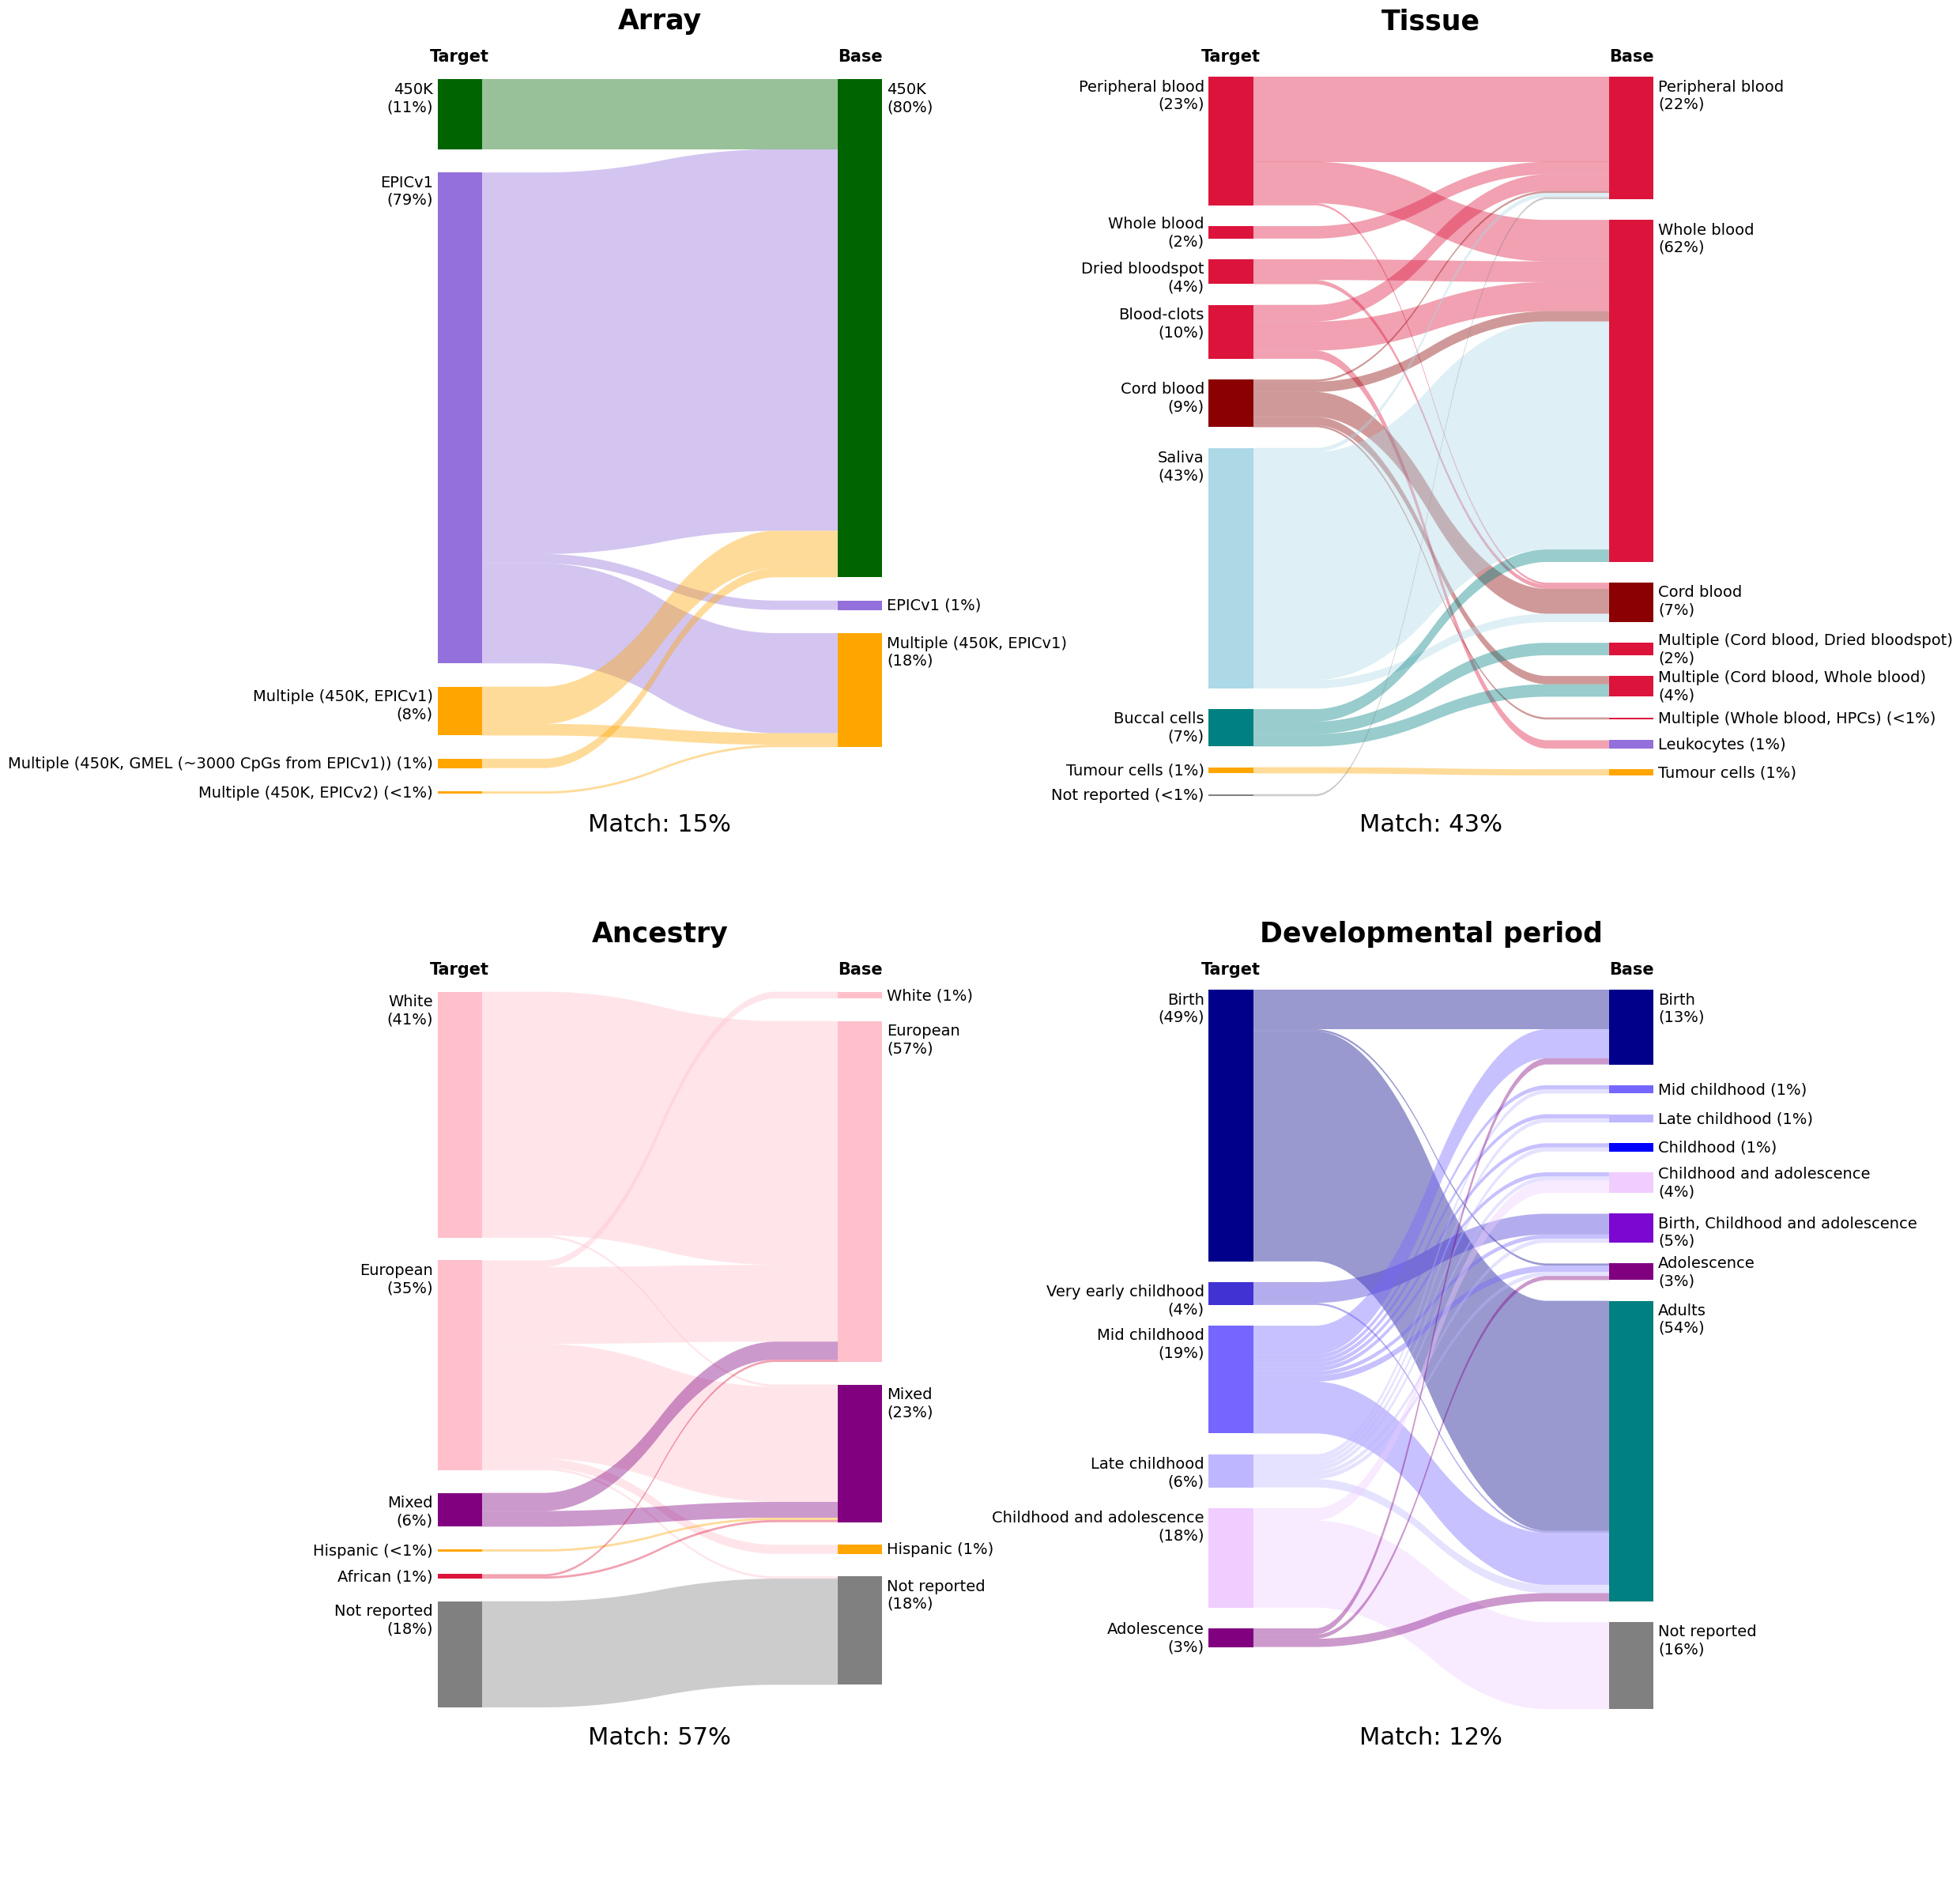

In [136]:
fig, axs = plt.subplot_mosaic('AB;ab;CD;cd', figsize=(20, 30),
                              height_ratios=[1,.2, 1,.2], gridspec_kw=dict(hspace=0, wspace=0.7))
    

a = sankey(axs['A'], var='Array', 
           left_labels = {'450K': {'color': 'darkgreen'}, 
                      'EPICv1': {'color': 'mediumpurple'},
                      'Multiple (450K, EPICv1)': {'color': 'orange'},
                      'Multiple (450K, GMEL (~3000 CpGs from EPICv1))': {'color': 'orange'},
                      'Multiple (450K, EPICv2)': {'color': 'orange'}},
           right_labels = {'450K': {'color': 'darkgreen'}, 
                       'EPICv1': {'color': 'mediumpurple'}, 
                       'Multiple (450K, EPICv1)': {'color': 'orange'}})

display_match(axs['a'], a)

b = sankey(axs['B'], var='Tissue',
           left_labels = {'Peripheral blood': {'color':'crimson'},
                          'Whole blood': {'color':'crimson'},
                          'Dried bloodspot': {'color':'crimson'},
                          'Blood-clots': {'color':'crimson'},
                          'Cord blood': {'color':'darkred'},
                          'Saliva': {'color':'lightblue'},
                          'Buccal cells': {'color':'teal'},
                          'Tumour cells': {'color':'orange'},
                          'Not reported': {'color':'grey'}}, 
           right_labels = {'Peripheral blood': {'color':'crimson'},
                           'Whole blood': {'color':'crimson'},
                           'Cord blood': {'color':'darkred'},
                           'Multiple (Cord blood, Dried bloodspot)': {'color':'crimson'},
                           'Multiple (Cord blood, Whole blood)': {'color':'crimson'},
                           'Multiple (Whole blood, HPCs)': {'color':'crimson'},
                           'Leukocytes': {'color':'mediumpurple'},
                           'Tumour cells': {'color':'orange'}})

display_match(axs['b'], b)

c = sankey(axs['C'], var='Ancestry',
           left_labels = {'White': {'color':'pink'}, 
                          'European': {'color':'pink'}, 
                          'Mixed': {'color':'purple'}, 
                          'Hispanic': {'color': 'orange'},
                          'African': {'color':'crimson'},
                          'Not reported': {'color': 'grey'}}, 
           right_labels = {'White': {'color':'pink'},
                           'European': {'color':'pink'},
                           'Mixed': {'color':'purple'}, 
                           'Hispanic': {'color': 'orange'},
                           'Not reported': {'color':'grey'}})

display_match(axs['c'], c)


dp = sankey(axs['D'], var='Developmental_period',
           left_labels = {'Birth': {'color':'darkblue'}, 
               'Very early childhood': {'color':'#4132d4'}, 
               'Mid childhood': {'color':'#7566ff'}, 
               'Late childhood': {'color':'#beb7ff'}, 
               'Childhood and adolescence': {'color':'#f0cdff'}, 
               'Adolescence': {'color':'purple'}},
           right_labels = {'Birth': {'color':'darkblue'}, 
                'Mid childhood': {'color':'#7566ff'}, 
                'Late childhood': {'color':'#beb7ff'}, 
                'Childhood': {'color':'blue'},
                'Childhood and adolescence': {'color':'#f0cdff'}, 
                'Birth, Childhood and adolescence': {'color':'#7b07d0'},
                'Adolescence': {'color':'purple'},
                'Adults':{'color':'teal'},
                'Not reported': {'color':'grey'}})

display_match(axs['d'], dp)

fig.savefig('Figure3.pdf', dpi=400, bbox_inches='tight')